# QRNN Classification

This notebook uses the QRNN trained on GPM surface precipitation to classify raining and non-raining pixels.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from torch.utils.data import DataLoader
from regn.data import GprofData
data = GprofData(os.path.expanduser("~/Dendrite/Projects/REGN/data/gprof_gmi/training_data_small.nc"),
                 batch_size = 64)
val_data = GprofData(os.path.expanduser("~/Dendrite/Projects/REGN/data/gprof_gmi/validation_data_small.nc"),
                 batch_size = 64)
 

### convert RR to labels, threshold 0.1mm/h is used


In [3]:
data.x = np.float64(data.x)
data.y = np.float64(data.y)

In [4]:
def add_labels(data):
    rain    = data.y > 0.1
    no_rain = data.y <= 0.1
    data.y[rain] = 1
    data.y[no_rain] = 0
    return data.y


In [5]:
data.y = add_labels(data)
val_data.y = add_labels(val_data)

In [6]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F


D_in = 28
H = 10
D_out = 2

In [7]:
#class Model(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.hidden = nn.Linear(D_in, H)
#        self.hidden1 = nn.Linear(H, H)
#        self.output = nn.Linear(H, D_out)
#        self.dropout = nn.Dropout(0.5)
  
#    def forward(self, x):
#        x = self.hidden(x)
#        x = torch.sigmoid(x)
#        x = self.dropout(x)
#        x = self.hidden1(x)
#        x = torch.sigmoid(x)        
#        x = self.output(x)
#        return x
#model = Model()    

In [8]:
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.Linear(H, H),
    nn.Sigmoid(),
    nn.Linear(H, D_out),
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)

In [10]:
losses = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, d in enumerate(data, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = d
        labels = labels.type(torch.LongTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))

            losses.append(running_loss/2000)
            running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 0.232
[1,  4000] loss: 0.168
[2,  2000] loss: 0.163
[2,  4000] loss: 0.161
[3,  2000] loss: 0.161
[3,  4000] loss: 0.159
[4,  2000] loss: 0.157
[4,  4000] loss: 0.158
[5,  2000] loss: 0.156
[5,  4000] loss: 0.155
[6,  2000] loss: 0.153
[6,  4000] loss: 0.154
[7,  2000] loss: 0.154
[7,  4000] loss: 0.150
[8,  2000] loss: 0.150
[8,  4000] loss: 0.149
[9,  2000] loss: 0.146
[9,  4000] loss: 0.147
[10,  2000] loss: 0.145
[10,  4000] loss: 0.144
[11,  2000] loss: 0.140
[11,  4000] loss: 0.143
[12,  2000] loss: 0.140
[12,  4000] loss: 0.140
[13,  2000] loss: 0.140
[13,  4000] loss: 0.137
[14,  2000] loss: 0.136
[14,  4000] loss: 0.137
[15,  2000] loss: 0.135
[15,  4000] loss: 0.135
[16,  2000] loss: 0.134
[16,  4000] loss: 0.134
[17,  2000] loss: 0.134
[17,  4000] loss: 0.132
[18,  2000] loss: 0.131
[18,  4000] loss: 0.133
[19,  2000] loss: 0.133
[19,  4000] loss: 0.130
[20,  2000] loss: 0.133
[20,  4000] loss: 0.131
[21,  2000] loss: 0.131
[21,  4000] loss: 0.131
[22,  2000

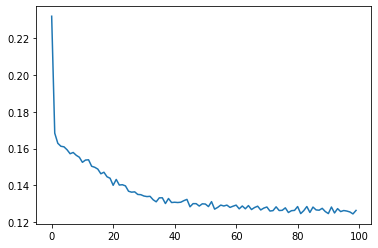

In [11]:
plt.plot(losses)

In [12]:
correct = 0
correct_rain = 0
total = 0
total_rain = 0
for i, d in enumerate(val_data, 0):

        inputs, labels = d
        labels = labels.type(torch.LongTensor)

        outputs = model(inputs.float())
        # find the index with maximum energy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

        correct_rain += ((predicted ==1) & (labels == 1)).sum().item()
        total_rain += (labels==1).sum().item()
print('Accuracy of the network: %d %%' % (
    100 * correct / total))  
print('Accuracy of the predicting rain: %d %%' % (
    100 * correct_rain / total_rain))  

Accuracy of the network: 95 %
Accuracy of the predicting rain: 62 %
